#Hidden Markov Models

In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pylab as plt

from IPython.display import Math

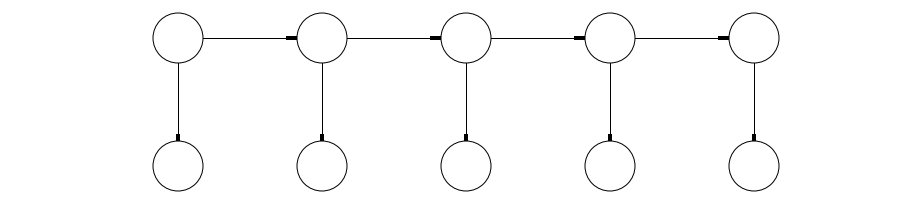

In [3]:

def makeDBN(inter, intra, T, labels):
    """Unfold a graph for T time slices"""
    N = max(max([i for i,j in inter]),max([j for i,j in inter]))+1

    G = np.zeros((N*T,N*T))
    pos = []
    all_labels = []
    for n in range(N):
        pos.append((0,-n))
        all_labels.append('$'+labels[n]+'_{'+str(0+1)+"}"+'$')
        
    for e in inter:
        s,d = e
        G[s,d] = 1

    for t in range(1,T):
        for n in range(N):
            pos.append((t,-n))
            all_labels.append('$'+labels[n]+'_{'+str(t+1)+"}"+'$')

        for e in inter:
            s,d = e
            s = s + N*t
            d = d + N*t
            G[s,d] = 1
        
        for e in intra:
            s,d = e
            s = s + N*(t-1)
            d = d + N*t
            G[s,d] = 1
    return G,pos,all_labels

#inter = [(0,1),(1,2),(2,3)]
#intra = [(0,0),(1,1),(0,1),(0,2)]
#variable_names = ["r","z","x", "y"] 
inter = [(0,1)]
intra = [(0,0)]
variable_names = ["x", "y"] 
T = 5

A, pos, label_list = makeDBN(inter, intra, T, variable_names)

G = nx.DiGraph(A)
labels = {i: s for i,s in enumerate(label_list)}
plt.figure(figsize=(12,2.5))
nx.draw(G, pos, node_color="white", node_size=2500, labels=labels, font_size=24, arrows=True)
plt.show()

##### Forward Pass

\begin{eqnarray}
p(y_{1:K}) & = & \sum_{x_{1:K}} p(y_{1:K}|x_{1:K}) p(x_{1:K}) \\
& = &  \underbrace{\sum_{x_K} p(y_K | x_K ) \sum_{x_{K-1}} p(x_K|x_{K-1})}_{\alpha_K}  \dots \sum_{x_{2}} p(x_3|x_{2})
                               \underbrace{p(y_{2}|x_{2})\overbrace{ \sum_{x_{1}} p(x_2|x_{1})}^{\alpha_{2|1}} }_{\alpha_2}
                                 \underbrace{p(y_{1}|x_{1})\overbrace{p(x_1)}^{\alpha_{1|0}}}_{\alpha_1}
\end{eqnarray}


##### Backward Pass

\begin{eqnarray}
p(y_{1:K}) & = &  \sum_{x_1} p(x_1) p(y_1 | x_1 )
%underbrace{\sum_{x_2} p(x_2|x_{1}) p(y_2 | x_2 )}_{\beta_1}
\dots
\underbrace{ \sum_{x_{K-1}} p(x_{K-1}|x_{K-2}) p(y_{K-1} | x_{K-1} )}_{\beta_{K-2}}
\underbrace{ \sum_{x_K} p(x_K|x_{K-1}) p(y_K | x_K )}_{\beta_{K-1}}
\underbrace{{\pmb 1}}_{\beta_{K}}
\end{eqnarray}





### Forward Pass



\begin{eqnarray}
\alpha_{1|0} & \equiv & p(x_1)
\end{eqnarray}

\begin{eqnarray}
\alpha_{k|k} & \equiv & p(y_{1:k}, x_k)
\end{eqnarray}

\begin{eqnarray}
\alpha_{k|k-1}  & \equiv & p(y_{1:k-1}, x_k)
\end{eqnarray}



For $k=1, 2, \dots, K$

__Predict__

$k=1$:

\begin{eqnarray}
\alpha_{1|0}(x_1) = p(x_1)
\end{eqnarray}

$k>1$:

\begin{eqnarray}
{\alpha_{k|k-1}(x_k)} & = & p(y_{1:k-1}, x_k) = \sum_{x_{k-1}} p(x_k| x_{k-1}) p(y_{1:k-1}, x_{k-1}) \\
& = & \sum_{x_{k-1}} p(x_k| x_{k-1}) { \alpha_{k-1|k-1}(x_{k-1}) }
\end{eqnarray}

__Update__

\begin{eqnarray}
{\alpha_{k|k}(x_k) } & = & p(y_{1:k}, x_k) = p(y_k | x_k) p(y_{1:k-1}, x_k) \\
 & = & p(y_k | x_k) {\alpha_{k|k-1}(x_k)}
\end{eqnarray}


### Backward Pass

\begin{eqnarray}
\beta_{k|k+1}(x_k) & \equiv & p(y_{k+1:K}| x_k) \\
\beta_{k|k}(x_k) & \equiv & p(y_{k:K}| x_k)
\end{eqnarray}


For $k=K, K-1, \dots, 1$

__'Postdict'__ : (Backward Prediction)

$k=K$
\begin{eqnarray}
{\beta_{K|K+1}(x_K)} & = & \mathbf{1} 
\end{eqnarray}


$k<K$
\begin{eqnarray}
{\beta_{k|k+1}(x_k)} & = & p(y_{k+1:K}| x_k) = \sum_{x_{k+1}} p(x_{k+1}| x_{k}) p(y_{k+1:K}| x_{k+1}) \\
& = & \sum_{x_{k+1}} p(x_{k+1}| x_{k}) {\beta_{k+1|k+1}(x_{k+1}) }
\end{eqnarray}

__Update__
\begin{eqnarray}
{\beta_{k|k}(x_k) } & = & p(y_{k:K}| x_k) = p(y_k | x_k) p(y_{k+1:K}| x_k) \\
 & = & p(y_k | x_k) {\beta_{k|k+1}(x_k)}
\end{eqnarray}

 

### Numerically Stable computation of $\log(\sum_i \exp (l_i ) ))$

Derivation

\begin{eqnarray}
L & = & \log(\sum_i \exp (l_i) ) 
 =   \log(\sum_i \exp (l_i) \frac{\exp(l^*)}{\exp(l^*)} ) \\
& = &  \log( \exp(l^*) \sum_i \exp (l_i - l^*) ) \\
& = &  l^* + \log( \sum_i \exp (l_i - l^*) )
\end{eqnarray}

Choose $l^*  =  \max_i l_i$

In [4]:
import numpy as np

def log_sum_exp_naive(l):
    return np.log(np.sum(np.exp(l)))

def log_sum_exp(l, axis=0):
    l_star = np.max(l, axis=axis, keepdims=True)
    return l_star + np.log(np.sum(np.exp(l - l_star),axis=axis,keepdims=True)) 
    
    
l = np.array([-1000, -10000])

print('Naive evaluation  :', log_sum_exp_naive(l))
print('Numerically stable:', log_sum_exp(l))



Naive evaluation  : -inf
Numerically stable: [-1000.]


/Users/cemgil/anaconda/envs/py33/lib/python3.3/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [6]:
# An implementation of the forward backward algorithm
# For numerical stability, we calculate everything in the log domain

# Defined in Sampling.ipynb
def normalize(A, axis=None):

    Z = np.sum(A, axis=axis,keepdims=True)
        
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def predict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(A,np.exp(lp-lstar)))

def postdict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(np.exp(lp-lstar), A))

def update(y, logB, lp):
    return logB[y,:] + lp


S = 3
R = 5
A = np.random.dirichlet(0.7*np.ones(S),S).T
B = np.random.dirichlet(0.7*np.ones(R),S).T
p = np.random.dirichlet(0.7*np.ones(S)).T

y = np.array([0, 1, 3, 2, 4])
T = y.shape[0]

logA = np.log(A)
logB = np.log(B)

# Forward Pass

# Python indexes starting from zero so
# log \alpha_{k|k} will be in log_alpha[:,k-1]
# log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]
log_alpha  = np.zeros((S, T))
log_alpha_pred = np.zeros((S, T))
for k in range(T):
    if k==0:
        log_alpha_pred[:,0] = np.log(p)
    else:
        log_alpha_pred[:,k] = predict(A, log_alpha[:,k-1])
    
    log_alpha[:,k] = update(y[k], logB, log_alpha_pred[:,k])
    
# Backward Pass
log_beta  = np.zeros((S, T))
log_beta_post = np.zeros((S, T))

for k in range(T-1,-1,-1):
    if k==T-1:
        log_beta_post[:,k] = np.zeros(S)
    else:
        log_beta_post[:,k] = postdict(A, log_beta[:,k+1])
    
    log_beta[:,k] = update(y[k], logB, log_beta_post[:,k])
    

In [7]:
def randgen(pr, N=1): 
    L = len(pr)
    return np.random.choice(range(L), size=N, replace=True, p=pr)

#Generate data from an HMM
S = 3
R = 5

pi = normalize(np.random.rand(S),axis=0)
A = normalize(np.random.rand(S,S),axis=0)
B = normalize(np.random.rand(R,S),axis=0)

# Number of steps
T = 100

x = np.zeros(T)
y = np.zeros(T)

for t in range(T):
    if t==0:
        x[t] = randgen(pi)
    else:
        x[t] = randgen(A[:,x[t-1]])
    
    y[t] = randgen(B[:,x[t]])
    


### Smoothing - Forward Backward Algorithm (Two filter formulation)
\begin{eqnarray}
p(y_{1:K}, x_k) & = & p(y_{1:k}, x_k) p(y_{k+1:K} | x_k) \\
& = & {\alpha_{k|k}(x_k) } {\beta_{k|k+1}(x_k)} \\
& \equiv & \gamma_k(x_k)
\end{eqnarray}

### Smoothing (Forward filtering - Backward smoothing), The Correction Smoother

Suppose we have computed the filtered quantities $p(x_t| y_{1:t})$ via the forward pass. The forward-backward algorithm requires us to store all observations. For batch settings, this is OK however when datapoints are arriving indeed sequentially, this may be not desired.  

We will derive a recursive algorithm to compute the marginals $p(x_t | y_{1:T})$.

Note that if we calculate instead the so-called __pairwise__ marginal $p(x_t, x_{t+1} | y_{1:T} )$, we can get by simple marginalization

\begin{align}
p(x_t | y_{1:T}) & =  \sum_{x_{t+1}} p(x_t, x_{t+1} | y_{1:T} )  & \text{Definition} 
\end{align}

\begin{align}
p(x_t, x_{t+1} | y_{1:T} ) & =   p(x_{t} |x_{t+1}, y_{1:t},y_{t+1:T} ) p(x_{t+1}|y_{1:T} ) & \text{Factorize} \\
& =   p(x_{t} |x_{t+1}, y_{1:t} ) p(x_{t+1}|y_{1:T} ) & \text{Conditional Independence}\\
  & =  \frac{p(x_{t}, x_{t+1}| y_{1:t} )}{p(x_{t+1}| y_{1:t} )} p(x_{t+1}|y_{1:T} ) & \text{Definition of Conditional} 
\end{align}

This update has the form:
\begin{eqnarray}
\text{New Pairwise Marginal}_{t,t+1} & = & \frac{\text{Old Pairwise Marginal}_{t,t+1}}{\text{Old Marginal}_{t+1}} \times {\text{New Marginal}_{t+1}} \\
\end{eqnarray}

The old pairwise marginal can be simply calculated from the filtered marginals as

\begin{align}
p(x_{t}, x_{t+1}| y_{1:t} ) & =  p(x_{t+1} | x_t,  y_{1:t} ) p(x_t | y_{1:t}) & \text{Definition} \\
& =  p(x_{t+1} | x_t ) p(x_t | y_{1:t}) & \text{Conditional Independence} \\
& = \text{Transition Model} \times \text{Filtering distribution} 
\end{align}



The correction smoother calculates a factorisation of the posterior of form

\begin{eqnarray}
p(x_{1:T}|y_{1:T}) & = & \frac{\prod_{t=1}^{T-1} p(x_{t}, x_{t+1} | y_{1:T}) }{ \prod_{t=2}^{T-1} p(x_{t} | y_{1:T}) }
\end{eqnarray}

In [8]:
# Smoother check
# All numbers must be equal to the marginal likelihood p(y_{1:K})

log_gamma = log_alpha + log_beta_post
print(log_sum_exp(log_gamma))

[[-8.87994484 -8.87994484 -8.87994484 -8.87994484 -8.87994484]]


In [9]:
# Correction Smoother
# For numerical stability, we calculate everything in the log domain
log_gamma_corr = np.zeros_like(log_alpha)
log_gamma_corr[:,T-1] = log_alpha[:,T-1]

for k in range(T-2,-1,-1):
    log_old_pairwise_marginal = log_alpha[:,k].reshape(1,N) + logA 
    log_old_marginal = predict(A, log_alpha[:,k])
    log_new_pairwise_marginal = log_old_pairwise_marginal + log_gamma_corr[:,k+1].reshape(N,1) - log_old_marginal.reshape(N,1)
    log_gamma_corr[:,k] = log_sum_exp(log_new_pairwise_marginal, axis=0).reshape(N)
    


IndexError: index 99 is out of bounds for axis 1 with size 5

In [10]:
# Verify that result coincide

print(log_gamma)
print(log_gamma_corr)



[[-10.68948229  -9.71378647  -9.99883499 -12.54701943 -13.31843027]
 [-10.92191026  -9.90603046  -9.35123798  -9.78244003 -10.32660117]
 [ -9.22738152 -10.45394088 -11.89255251  -9.44400874  -9.16386034]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


### Implementation as a Python Object

We will integrate filtering, smoothing and training functionality into an HMM object. 

In [11]:
def randgen(pr, N=1): 
    L = len(pr)
    return np.random.choice(range(L), size=N, replace=True, p=pr)

def log_sum_exp(l, axis=0):
    l_star = np.max(l, axis=axis, keepdims=True)
    return l_star + np.log(np.sum(np.exp(l - l_star),axis=axis,keepdims=True)) 

def normalize_exp(log_P, axis=None):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize(np.exp(log_P - a), axis=axis)
    return P

In [12]:
class HMM(object):
    def __init__(self, pi, A, B):
        # p(x_0)
        self.pi = pi
        # p(x_k|x_{k-1})
        self.A = A
        # p(y_k|x_{k})
        self.B = B
        # Number of possible latent states at each time
        self.S = pi.shape[0]
        # Number of possible observations at each time
        self.R = B.shape[0]
        self.logB = np.log(self.B)
        self.logA = np.log(self.A)
        self.logpi = np.log(self.pi)
    
    @classmethod
    def from_random_parameters(cls, S=3, R=5):
        A = np.random.dirichlet(0.7*np.ones(S),S).T
        B = np.random.dirichlet(0.7*np.ones(R),S).T
        pi = np.random.dirichlet(0.7*np.ones(S)).T
        return cls(pi, A, B)
        
    def __str__(self):
        s = "Prior:\n" + str(self.pi) + "\nA:\n" + str(self.A) + "\nB:\n" + str(self.B)
        return s
    
    def __repr__(self):
        s = self.__str__()
        return s

    def predict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(self.A,np.exp(lp-lstar)))

    def postdict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(np.exp(lp-lstar), self.A))

    def update(self, y, lp):
        return self.logB[y,:] + lp

    def generate_sequence(self, T=10):
    # T: Number of steps

        x = np.zeros(T)
        y = np.zeros(T)

        for t in range(T):
            if t==0:
                x[t] = randgen(pi)
            else:
                x[t] = randgen(A[:,x[t-1]])    
            y[t] = randgen(B[:,x[t]])
    
        return y, x

    def forward(self, y):
        T = len(y)
        
        # Forward Pass

        # Python indexes starting from zero so
        # log \alpha_{k|k} will be in log_alpha[:,k-1]
        # log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]
        log_alpha  = np.zeros((self.S, T))
        log_alpha_pred = np.zeros((self.S, T))
        for k in range(T):
            if k==0:
                log_alpha_pred[:,0] = self.logpi
            else:
                log_alpha_pred[:,k] = self.predict(log_alpha[:,k-1])

            log_alpha[:,k] = self.update(y[k], log_alpha_pred[:,k])
            
        return log_alpha, log_alpha_pred
            
    def backward(self, y):
        # Backward Pass
        T = len(y)
        log_beta  = np.zeros((self.S, T))
        log_beta_post = np.zeros((self.S, T))

        for k in range(T-1,-1,-1):
            if k==T-1:
                log_beta_post[:,k] = np.zeros(self.S)
            else:
                log_beta_post[:,k] = self.postdict(log_beta[:,k+1])

            log_beta[:,k] = self.update(y[k], log_beta_post[:,k])

        return log_beta, log_beta_post
        
    def forward_backward_smoother(self, y):
        log_alpha, log_alpha_pred = self.forward(y)
        log_beta, log_beta_post = self.backward(y)
        
        log_gamma = log_alpha + log_beta_post
        return log_gamma
        
    def correction_smoother(self, y):
        # Correction Smoother

        log_alpha, log_alpha_pred = self.forward(y)
        T = len(y)
        
        # For numerical stability, we calculate everything in the log domain
        log_gamma_corr = np.zeros_like(log_alpha)
        log_gamma_corr[:,T-1] = log_alpha[:,T-1]

        SS = np.zeros((self.S, self.S))
        for k in range(T-2,-1,-1):
            log_old_pairwise_marginal = log_alpha[:,k].reshape(1,self.S) + self.logA 
            log_old_marginal = self.predict(log_alpha[:,k])
            log_new_pairwise_marginal = log_old_pairwise_marginal + log_gamma_corr[:,k+1].reshape(self.S,1) - log_old_marginal.reshape(self.S,1)
            log_gamma_corr[:,k] = log_sum_exp(log_new_pairwise_marginal, axis=0).reshape(self.S)
            SS = SS + normalize_exp(log_new_pairwise_marginal)
    
        return log_gamma_corr, SS
    
hm = HMM.from_random_parameters()

y,x = hm.generate_sequence(10)

log_alpha, log_alpha_pred = hm.forward(y)
log_gamma = hm.forward_backward_smoother(y)
log_gamma_corr = hm.correction_smoother(y)


In [13]:
print(log_gamma)

print(log_gamma_corr)

[[-20.68436977 -20.16368287 -23.51931757 -22.5298158  -21.28041739
  -22.8720213  -22.17330391 -22.78897447 -23.75574978 -23.78393119]
 [-20.05680669 -20.79498659 -21.06107756 -19.9249109  -20.1356557
  -20.98446633 -20.15514972 -21.15550253 -21.11030921 -20.95399229]
 [-25.96029624 -21.88938111 -19.92669236 -21.22380158 -21.20164428
  -19.97868788 -20.73048385 -19.92732557 -19.9056686  -19.9571028 ]]
(array([[-20.68436977, -20.16368287, -23.51931757, -22.5298158 ,
        -21.28041739, -22.8720213 , -22.17330391, -22.78897447,
        -23.75574978, -23.78393119],
       [-20.05680669, -20.79498659, -21.06107756, -19.9249109 ,
        -20.1356557 , -20.98446633, -20.15514972, -21.15550253,
        -21.11030921, -20.95399229],
       [-25.96029624, -21.88938111, -19.92669236, -21.22380158,
        -21.20164428, -19.97868788, -20.73048385, -19.92732557,
        -19.9056686 , -19.9571028 ]]), array([[  2.02169172e-03,   1.03242272e+00,   8.57065201e-03],
       [  5.57832725e-01,   1.1613

### Estimating parameters of an homogeneous Markov chain
$\newcommand{\ind}[1]{\left[{#1}\right]}$

We have a Markov chain with transition probabilities $p(x_t = i| x_{t-1} = j) =  A_{i,j}$
and initial state $p(x_1) = \pi_i$.

The distributions are
\begin{eqnarray}
p(x_1 |\pi)& = &\prod_{s=1}^{S} \pi_s^{\ind{s = x_1}} \\
p(x_t | x_{t-1}, A) &=& \prod_{j=1}^{S} \prod_{s=1}^{S}  A_{s,j}^{{\ind{s = x_t}}\ind{j = x_{t-1}}} \\
\end{eqnarray}

The loglikelihood is
\begin{eqnarray}
{\cal L}(\pi, A) & = & \log \left( p(x_1 | \pi) \prod_{t=2}^T p(x_t | x_{t-1}, A) \right) \\
& = & \sum_{s=1}^{S} {\ind{s = x_1}} \log \pi_s + \sum_{t=2}^T \sum_{j=1}^{S}\sum_{s=1}^{S} {{\ind{s = x_t}}\ind{j = x_{t-1}}} \log A_{s,j}
\end{eqnarray}

We have the constraints $\sum_s \pi_s = 1$ and $\sum_i A_{i,j} = 1$ for all $j=1 \dots S$ so we have $S+1$ constraints. We write the Lagrangian
\begin{eqnarray}
\Lambda(\pi, A, \lambda^\pi, \lambda^A) & = & \sum_{s=1}^{S} {\ind{s = x_1}} \log \pi_s + \sum_{t=2}^T \sum_{j=1}^{S} \sum_{s=1}^{S} {{\ind{s = x_t}}\ind{j = x_{t-1}}} \log A_{s,j} \\
& & + \lambda^\pi \left( 1 - \sum_s \pi_s \right) + \sum_j \lambda^A_j \left( 1 - \sum_s A_{s,j} \right)
\end{eqnarray}

To find $\pi$ and $A$ we take the derivative of the Lagrangian
\begin{eqnarray}
\frac{\partial \Lambda(\pi, A,\lambda^\pi, \lambda^A)}{\partial \pi_i} & = & {\ind{i = x_1}} \frac{1}{\pi_i} - \lambda^\pi = 0\\
\frac{\partial \Lambda(\pi, A, \lambda^\pi, \lambda^A)}{\partial A_{i,j}} & = & \sum_{t=2}^T {{\ind{i = x_t}}\ind{j = x_{t-1}}} \frac{1}{A_{i,j}} - \lambda^A_j = 0
\end{eqnarray}

Substitute the constraints $\sum_s \pi_s = 1$ and $\sum_s A_{s,j} = 1, \; j=1\dots S$.

\begin{eqnarray}
\pi_i & = & {\ind{i = x_1}} \frac{1}{\lambda^\pi} \\
\sum_i \pi_i & = & \frac{1}{\lambda^\pi} \sum_i {\ind{i = x_1}} = 1\\
\lambda^\pi & = & 1\\
\pi_i & = & {\ind{i = x_1}}
\end{eqnarray}
As we have effectively only a single observation for $x_1$, we have a crisp estimate.

\begin{eqnarray}
A_{i,j} & = & \sum_{t=2}^T {{\ind{i = x_t}}\ind{j = x_{t-1}}} \frac{1}{\lambda^A_j} \\
\sum_i A_{i,j} & = & \sum_i \sum_{t=2}^T {{\ind{i = x_t}}\ind{j = x_{t-1}}} \frac{1}{\lambda^A_j} = 1 \\
\lambda^A_j & = & \sum_{t=2}^T \sum_i  {{\ind{i = x_t}}\ind{j = x_{t-1}}} \\
A_{i,j} & = & \frac{\sum_{t=2}^T {{\ind{i = x_t}}\ind{j = x_{t-1}}}}{\sum_{t=2}^T \sum_i  {{\ind{i = x_t}}\ind{j = x_{t-1}}}}\\
& = & \frac{\sum_{t=2}^T {{\ind{i = x_t}}\ind{j = x_{t-1}}}}{\sum_{t=2}^T \ind{j = x_{t-1}}}
\end{eqnarray}
The result is intuitive. The denominator counts the number of times the chain visited state $j$ in the previous state. The numerator counts the number of times we visit $i$ given we were at $j$ the previous time.


### Estimating parameters a homogeneous Markov chain when several sequences are observed

Suppose we have observed several sequences
\begin{eqnarray}
X = \{x_1^{(n)}, x_2^{(n)}, \dots, x_{T_n}^{(n)}   \}
\end{eqnarray}
for $n = 1\dots N$. Here $T_n$ is the length of the $n$'th sequence.

The notation becomes slightly more complicated but conceptully the derivation is similar.

The joint probability of all sequences is
\begin{eqnarray}
p(X | \pi, A) & = & \prod_n \left( p(x_1^{(n)}) \prod_{t=2}^{T_n} p(x_t^{(n)}| x_{t-1}^{(n)} ) \right)
\end{eqnarray}
The loglikelihood is
\begin{eqnarray}
{\cal L}(\pi, A) & = & \sum_n \left( \log p(x_1^{(n)}) + \sum_{t=2}^{T_n} \log p(x_t^{(n)}| x_{t-1}^{(n)} ) \right) \\
& = & \sum_n \left( \sum_{s=1}^{S} {\ind{s = x_1^{(n)}}} \log \pi_s + \sum_{t=2}^{T_n}\sum_{j=1}^{S}
\sum_{s=1}^{S} {\ind{s = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}} \log A_{s,j} \right) \\
& = & \sum_{s=1}^{S} \sum_n  {\ind{s = x_1^{(n)}}} \log \pi_s + \sum_n \sum_{t=2}^{T_n}
\sum_{j=1}^{S} \sum_{s=1}^{S}   {\ind{s = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}} \log A_{s,j}
\end{eqnarray}


We write the Lagrangian

\begin{eqnarray}
\Lambda(\pi, A, \lambda^\pi, \lambda^A)
& = & \sum_{s=1}^{S} \sum_n  {\ind{s = x_1^{(n)}}} \log \pi_s + \sum_n  \sum_{t=2}^{T_n} \sum_{j=1}^{S}
\sum_{s=1}^{S}  {\ind{s = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}} \log A_{s,j} \\
& & + \lambda^\pi \left( 1 - \sum_s \pi_s \right) + \sum_j \lambda^A_j \left( 1 - \sum_s A_{s,j} \right)
\end{eqnarray}

To find $\pi$ and $A$ we take the derivative of the Lagrangian
\begin{eqnarray}
\frac{\partial \Lambda(\pi, A,\lambda^\pi, \lambda^A)}{\partial \pi_i} & = & \sum_n {\ind{i = x_1^{(n)}}} \frac{1}{\pi_i} - \lambda^\pi = 0\\
\frac{\partial \Lambda(\pi, A, \lambda^\pi, \lambda^A)}{\partial A_{i,j}} & = &  \sum_n \sum_{t=2}^{T_n} {{\ind{i = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}}} \frac{1}{A_{i,j}} - \lambda^A_j = 0
\end{eqnarray}

#### Prior
\begin{eqnarray}
\pi_i & = & \sum_n {\ind{i = x_1^{(n)}}} \frac{1}{\lambda^\pi}\\
\sum \pi_i & = & \frac{1}{\lambda^\pi} \sum_i \sum_n {\ind{i = x_1^{(n)}}} = 1 \\
\lambda^\pi & = & \sum_i \sum_n {\ind{i = x_1^{(n)}}} = N \\
\pi_i & = & \frac{1}{N} \sum_n {\ind{i = x_1^{(n)}}}
\end{eqnarray}

#### Transition Matrix

\begin{eqnarray}
A_{i,j} & = & \sum_n \sum_{t=2}^{T_n}  {{\ind{i = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}}} \frac{1}{\lambda^A_j} \\
\sum_i A_{i,j} & = & \sum_i \sum_n \sum_{t=2}^{T_n} {{\ind{i = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}}} \frac{1}{\lambda^A_j} = 1 \\
\lambda^A_j & = & \sum_i \sum_n  \sum_{t=2}^{T_n} {{\ind{i = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}}} \\
& = &  \sum_n \sum_{t=2}^{T_n}  \ind{j = x_{t-1}^{(n)}} \\
A_{i,j} & = &  \frac{\sum_n \sum_{t=2}^{T_n}  {{\ind{i = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}}}}{\sum_n \sum_{t=2}^{T_n}  {\ind{j = x_{t-1}^{(n)}}}}
\end{eqnarray}

### The EM Algorithm

$\newcommand{\E}[1]{\left\langle#1\right\rangle}$

The EM algorithm is a standart approach for ML estimation, when we have hidden variables.
The canonical model is $p(y, x| \theta)$ where we observe only $y$.

The observed data loglikelihood is
\begin{eqnarray}
{\cal L}(\theta) & = & \log p(y| \theta) = \log \sum_x p(y, x| \theta)
\end{eqnarray}

The key to the EM algorithm is the Jensen's inequality, that states for a concave function $f$ we have for $0 \leq \lambda \leq 1$


\begin{eqnarray}
f(\lambda x_1 + (1 - \lambda) x_2) \geq \lambda f( x_1) + (1 - \lambda) f(x_2)
\end{eqnarray}

In words the value of a function evaluated at the convex combination (lhs) is always equal and larger then the convex combination of the function values. As mathematical expectation
\begin{eqnarray}
\E{f(x)} & = & \sum_x p(x) f(x) \\
\sum_x p(x) & = & 1
\end{eqnarray}

As $\log(x)$  is a concave function, we have

\begin{eqnarray}
 f(\E{x}) & \geq & \E{f(x)}
\end{eqnarray}

The key idea of the EM algorithm is to lower bound the observed data likelihood an maximize the bound with respect to the parameters. We take any distribution $q(x)$
\begin{eqnarray}
{\cal L}(\theta) & = & \log \sum_x p(y, x| \theta) \\
& = & \log \sum_x p(y, x| \theta) \frac{q(x)}{q(x)} \\
& = & \log  \E{\frac{p(y, x| \theta)}{q(x)}}_{q(x)}\\
& \geq & \E{\log {p(y, x| \theta)}}_{q(x)} -\E{\log{q(x)} }_{q(x)}\\
\end{eqnarray}
For _any_ $q(x)$, we have a lower bound. The natural strategy here is to choose the $q(x)$ that will maximise the lower bound. This is an optimisation problem. To make the notation more familiar, we let $q(x = i) = q_i$. Then, we arrive at the Lagrangian
\begin{eqnarray}
\Lambda(q, \lambda) & = & \sum_i q_i \log p(y, x=i| \theta) - \sum_i q_i \log q_i \\
& & + \lambda (1 - \sum_i q_i)
\end{eqnarray}
We take the derivative with respect to $q_i$
\begin{eqnarray}
\frac{\partial \Lambda(q, \lambda)}{\partial q_k} & = & \log p(y, x=k| \theta) - (\log q_k + 1) - \lambda = 0\\
\log q_k  & = & \log p(y, x=k| \theta) -1 - \lambda \\
q_k  & = & p(y, x=k| \theta) \exp(-1 - \lambda) \\
\sum_k q_k & = & \exp(-1 - \lambda) \sum_k p(y, x=k| \theta) = 1\\
\exp(1 + \lambda) & = & p(y | \theta) \\
\exp(-1 - \lambda) & = & 1/p(y | \theta) \\
\end{eqnarray}
hence we have
\begin{eqnarray}
q_k  & = & p(y, x=k| \theta)/p(y | \theta) = p(x=k| y \theta)
\end{eqnarray}
This result shows that the best we can do is to choose the posterior distribution
\begin{eqnarray}
q(x) & = & p(x| y, \theta)
\end{eqnarray}
The EM algorithm is an iterative algorithm that exploits this bound result. Given a particular parameter setting $\theta^{(\tau)}$ at iteration $\tau$, we can compute a lower bound of the true likelihood function.
\begin{eqnarray}
{\cal L}(\theta) & \geq & \E{\log {p(y, x| \theta)}}_{p(x| y, \theta^{(\tau)})} -\E{\log p(x| y, \theta^{(\tau)}) }_{p(x| y, \theta^{(\tau)})}\\
& \equiv & {\cal F}[\theta; \theta^{(\tau)}] +  H[p(x| y, \theta^{(\tau)})]
\end{eqnarray}
We need to show that
\begin{eqnarray}
{\cal L}(\theta^{(\tau)}) & = & \E{\log {p(y, x| \theta)}}_{p(x| y, \theta^{(\tau)})} -\E{\log p(x| y, \theta^{(\tau)}) }_{p(x| y, \theta^{(\tau)})}\\
& = & {\cal F}[\theta^{(\tau)}; \theta^{(\tau)}] +  H[p(x| y, \theta^{(\tau)})]
\end{eqnarray}
In other words, the bound is tight at $\theta^{(\tau)}$, hence maximizing the bound guarantees maximization of the true loglikelihoood.

In most cases, where the EM algorithm can be applied, the joint distribution is from an {\it exponential family}, i.e., it has the generic algebraic form
\begin{eqnarray}
p(y, x| \theta) & = & b(y, x)\exp( \sum_l \phi_l(y, x) \psi(\theta_l) - A(\theta)   )
\end{eqnarray}
where $\phi_l$ are the sufficient statistics and $\psi(\theta_l)$ are the {\it canonical} parameters. The canonical parameters are in one to one relation with a conventional parametrisation. We will give several explicit examples when we cover the HMM's of the next section.

In the case when the complete data likelihood is an exponential family, the computation of the bound requires the expectation
\begin{eqnarray}
\E{\log p(y, x| \theta)} & = & \E{\log b(x, y)} + \sum_l \E{\phi_l(y, x)} \psi(\theta_l) - A(\theta)
\end{eqnarray}
where the expectation is taken with respect to the posterior $p(x|y, \theta^{(\tau)})$. In other words, we need to compute expectations of form $\E{\phi_l(y, x)}$. Once these are available, we have effectively an expression for ${\cal F}(\theta; \theta^{(\tau)})$. By maximisation of ${\cal F}$ with respect to $\theta$,  and arrive at $\theta^{(\tau + 1)}$ and complete the iteration.

In a rather abstract sense, the EM algorithm proceeds as follows:

##### The Expectation/Maximization (EM) algorithm.

\begin{algorithmic}
\STATE Initialise $\theta^{(0)}$
\FOR{  $\text{epoch} = 1 \dots $  MAXITER}
\STATE E-step. Compute the sufficient statistics of the complete data likelihood
\STATE M-step. Maximize with respect to the parameters $\theta$ to find $\theta^{(\tau + 1)}$
\ENDFOR
\end{algorithmic}


### Learning HMM parameters by EM

Suppose we have observed several sequences
\begin{eqnarray}
Y = \{y_1^{(n)}, y_2^{(n)}, \dots, y_{T_n}^{(n)}   \}
\end{eqnarray}
for $n = 1\dots N$. Here $T_n$ is the length of the $n$'th sequence.
Let $Y \in \{1,\dots, R\}$ and $X \in \{1,\dots, S \}$.

The discrete observation, discrete state space HMM has the following factors:
\begin{eqnarray}
p(x_1 = i) & = & \pi_i \\
p(y_k = r| x_k = i) & = & B_{r,i} \\
p(x_k = i| x_{k-1} = j) & = & A_{i,j} 
\end{eqnarray}


The joint probability of all observed sequences and corresponding hidden sequences are
\begin{eqnarray}
p(Y, X | \pi, A, B) & = & \prod_n \left( p(x_1^{(n)}) p(y_1^{(n)} | x_1^{(n)})  \prod_{t=2}^{T_n} p(y_t^{(n)} | x_t^{(n)}) p(x_t^{(n)}| x_{t-1}^{(n)} ) \right)
\end{eqnarray}
The coplete data loglikelihood is

\begin{eqnarray}
{\cal L}(\pi, A, B) & = & \sum_n \left( \log p(x_1^{(n)}) + \sum_{t=1}^{T_n} \log p(x_t^{(n)}| x_{t-1}^{(n)} ) + \sum_{t=2}^{T_n} \log p(y_t^{(n)} | x_t^{(n)}) \right) \\
& = & \sum_n \left( \sum_{s=1}^{S} {\ind{s = x_1^{(n)}}} \log \pi_s   + \log \pi_s \sum_{t=2}^{T_n}\sum_{j=1}^{S}
\sum_{s=1}^{S} {\ind{s = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}} \log A_{s,j} + \sum_{t=1}^{T_n}\sum_{r=1}^{R}
\sum_{i=1}^{S} {\ind{r = y_t^{(n)}}}\ind{i = x_{t}^{(n)}} \log B_{r,i}\right) \\
& = & \sum_n \sum_{s=1}^{S}   {\ind{s = x_1^{(n)}}} \log \pi_s  + \sum_n \sum_{t=2}^{T_n}
\sum_{j=1}^{S} \sum_{s=1}^{S}   {\ind{s = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}} \log A_{s,j} + \sum_n \sum_{t=1}^{T_n}\sum_{r=1}^{R}
\sum_{i=1}^{S} {\ind{r = y_t^{(n)}}}\ind{i = x_{t}^{(n)}} \log B_{r,i} \\
& = & \sum_{s=1}^{S} \underbrace{\left( \sum_n  {\ind{s = x_1^{(n)}}} \right)}_{\equiv C_1} \log \pi_s  + 
\sum_{j=1}^{S} \sum_{s=1}^{S} \underbrace{\left(  \sum_n \sum_{t=2}^{T_n} {\ind{s = x_t^{(n)}}}\ind{j = x_{t-1}^{(n)}} \right)}_{\equiv C_2} \log A_{s,j} + \sum_{r=1}^{R}
\sum_{i=1}^{S} \underbrace{\left(  \sum_n \sum_{t=1}^{T_n} {\ind{r = y_t^{(n)}}}\ind{i = x_{t}^{(n)}} \right)}_{\equiv C_3} \log B_{r,i} 
\end{eqnarray}

We write the Lagrangian to ensure that the columns of $A$ and $B$ are positive and normalized

\begin{eqnarray}
\Lambda(\pi, A, \lambda^\pi, \lambda^A, \lambda^B)
& = & \sum_{s=1}^{S} C_1(s) \log \pi_s + \sum_{j=1}^{S}
\sum_{s=1}^{S}  C_2(s,j) \log A_{s,j} + \sum_{r=1}^{R}
\sum_{i=1}^{S} C_3(r,i) \log B_{r,i} \\
& & + \lambda^\pi \left( 1 - \sum_s \pi_s \right) + \sum_j \lambda^A_j \left( 1 - \sum_s A_{s,j} \right)
+ \sum_i \lambda^B_i \left( 1 - \sum_r B_{r,i} \right)
\end{eqnarray}

To find $\pi$, $A$ and $B$ we take the derivative of the Lagrangian
\begin{eqnarray}
\frac{\partial \Lambda(\pi, A,\lambda^\pi, \lambda^A, \lambda^B)}{\partial \pi_i} & = & C_1(i) \frac{1}{\pi_i} - \lambda^\pi = 0\\
\frac{\partial \Lambda(\pi, A, \lambda^\pi, \lambda^A, \lambda^B)}{\partial A_{i,j}} & = &  C_2(i,j) \frac{1}{A_{i,j}} - \lambda^A_j = 0 \\
\frac{\partial \Lambda(\pi, B, \lambda^\pi, \lambda^A, \lambda^B)}{\partial B_{k,i}} & = &  C_3(k,i) \frac{1}{B_{k,i}} - \lambda^B_i = 0 \\
\end{eqnarray}

#### Prior
We set the derivative to zero and solve for $\pi$
\begin{eqnarray}
\pi_i & = & C_1(i) \frac{1}{\lambda^\pi}
\end{eqnarray}
As we have the normalization constraint for $\pi$, we also have the following equality from which we can solve for the Lagrange multiplier:
\begin{eqnarray}
\sum_i \pi_i & = & \frac{1}{\lambda^\pi} \sum_i C_1(i) = 1 \\
\lambda^\pi & = & \sum_i  C_1(i)  = N 
\end{eqnarray}
Substituting, we obtain the intuitive answer:
\begin{eqnarray}
\pi_i & = & \frac{1}{N} C_1(i)
\end{eqnarray}

#### Transition Matrix

\begin{eqnarray}
A_{i,j} & = & C_2(i,j) \frac{1}{\lambda^A_j} \\
\sum_i A_{i,j} & = & \sum_i C_2(i,j) \frac{1}{\lambda^A_j} = 1 \\
\lambda^A_j & = & \sum_i C_2(i,j) \\
A_{i,j} & = &  \frac{C_2(i,j)}{\sum_i C_2(i,j)}
\end{eqnarray}

#### Observation Matrix
\begin{eqnarray}
B_{k,i} & = & C_3(k,i) \frac{1}{\lambda^B_i} \\
\sum_k B_{k,i} & = & \sum_k C_3(k,i) \frac{1}{\lambda^B_i} = 1 \\
\lambda^B_i & = & \sum_k C_3(k,i) \\
B_{k,i} & = &  \frac{C_3(k,i)}{\sum_k C_3(k,i)}
\end{eqnarray}


In [206]:
S = 3
R = 5
A = np.random.dirichlet(0.7*np.ones(S),S).T
B = np.random.dirichlet(0.7*np.ones(R),S).T
p = np.random.dirichlet(0.7*np.ones(S)).T

y = np.array([0, 1, 3, 2, 4])

hm = HMM(p, A, B)

The cells below are not finished yet

\begin{eqnarray}
C_2 &=& \sum_{x_1} \sum_{x_2} \left( \sum_{j=1}^{S} \sum_{s=1}^{S} {\ind{s = x_2}}\ind{j = x_{1}} + \sum_{j=1}^{S} \sum_{s=1}^{S} {\ind{s = x_3}}\ind{j = x_{2}} \right) p(x_1|y_1, x_2) p(x_2|y_{1,2}) \\
C_2(a,b) &=&  \sum_{x_2} \left(\sum_{x_1} \sum_{j=1}^{S} \sum_{s=1}^{S} {\ind{s = x_2}}\ind{j = x_{1}} \ind{a = s} \ind{b = j} p(x_1|y_1, x_2) + \sum_{j=1}^{S} \sum_{s=1}^{S} {\ind{s = x_3}}\ind{j = x_2} \ind{a = s} \ind{b = j}\right)  p(x_2|y_{1,2}) \\
&=&  \sum_{x_2} \left(\sum_{x_1} {\ind{a = x_2}}\ind{b = x_{1}} p(x_1|y_1, x_2) + {\ind{a = x_3}}\ind{b = x_2} \right)  p(x_2|y_{1,2}) \\
&=&  \sum_{x_2} \left({\ind{a = x_2}} p(x_1=b|y_1, x_2) + {\ind{a = x_3}}\ind{b = x_2} \right)  p(x_2|y_{1,2}) \\
 & =&  p(x_1=b|y_1, x_2=a) p(x_2=a|y_{1,2}) +   \ind{a = x_{3}}  p(x_2=b|y_{1,2})  \\
\end{eqnarray}


### Forward smoothers

The EM algorithm requires obtaining the sufficient statistics of an HMM.  

The key observation is that the sufficient statistics are additive:
\begin{eqnarray}
C_t & = & \int \left(\sum_{k=2}^t s_k(x_{k-1}, x_{k}) \right) p(x_{1:t}|y_{1:t}) dx_{1:t}
\end{eqnarray}

We will use this observation as the basis of a forward recursion. First we decompose the posterior 
as a product of the filtering density at time $t$ and a conditional quantity familiar from the correction smoother 
\begin{eqnarray}
C_t & = & \int \int \left(\sum_{k=2}^t s_k(x_{k-1}, x_{k})\right) p(x_{1:t-1}|y_{1:t},x_t) p(x_{t}|y_{1:t}) dx_{1:t-1} dx_t \\
& = & \int \underbrace{\left( \int \left(\sum_{k=2}^t s_k(x_{k-1}, x_{k})\right) p(x_{1:t-1}|y_{1:t-1},x_t) dx_{1:t-1} \right)}_{=V_t(x_t)} p(x_{t}|y_{1:t})  dx_t
\end{eqnarray}

Due to additivity, we can decompose further
\begin{eqnarray}
V_t(x_t) & = & \int \left( s_t(x_{t-1}, x_{t}) + \sum_{k=2}^{t-1} s_k(x_{k-1}, x_{k})  \right) p(x_{1:t-1}|y_{1:t-1}, x_t) dx_{1:t-1} \\
& = & \int \int \left( s_t(x_{t-1}, x_{t}) + \sum_{k=2}^{t-1} s_k(x_{k-1}, x_{k})  \right) p(x_{1:t-2}|y_{1:t-1}, x_{t-1}, x_t) p(x_{t-1}|y_{1:t-1}, x_t) dx_{1:t-2} dx_{t-1} \\
& = & \int \int \left( s_t(x_{t-1}, x_{t}) + \sum_{k=2}^{t-1} s_k(x_{k-1}, x_{k})  \right) p(x_{1:t-2}|y_{1:t-2}, x_{t-1}) p(x_{t-1}|y_{1:t-1}, x_t) dx_{1:t-2} dx_{t-1} \\
& = & \int \left( s_t(x_{t-1}, x_{t}) + \int \sum_{k=2}^{t-1} s_k(x_{k-1}, x_{k}) p(x_{1:t-2}|y_{1:t-2}, x_{t-1}) dx_{1:t-2}  \right)  p(x_{t-1}|y_{1:t-1}, x_t)  dx_{t-1} \\
& = & \int \left( s_t(x_{t-1}, x_{t}) + V_{t-1}(x_{t-1})  \right)  p(x_{t-1}|y_{1:t-1}, x_t)  dx_{t-1}
\end{eqnarray}





\begin{eqnarray}
V_1(x_1) & = & 0 \\
V_2(x_2) & = & \int  s_2(x_{1}, x_{2})   p(x_{1}|y_{1}, x_2)  dx_{1} \\
V_3(x_3) & = & \int \left( s_3(x_{2}, x_{3}) + V_{2}(x_{2})  \right)  p(x_{2}|y_{1:2}, x_3)  dx_{2}
\end{eqnarray}




In [429]:

    
S = 3
R = 5
#A = np.random.dirichlet(0.7*np.ones(S),S).T
#B = np.random.dirichlet(0.7*np.ones(R),S).T
#p = np.random.dirichlet(0.7*np.ones(S)).T

y = np.array([1, 1, 1])


hm = HMM(p, A, B)

T = y.shape[0]

logA = np.log(A)
logB = np.log(B)

# Forward Pass

log_alpha  = np.zeros((S, T))
log_alpha_pred = np.zeros((S, T))

V  = np.zeros((S,S, T))

for k in range(T):
    if k==0:
        log_alpha_pred[:,0] = np.log(p)
    else:
        log_alpha_pred[:,k] = predict(A, log_alpha[:,k-1])
    
    log_alpha[:,k] = update(y[k], logB, log_alpha_pred[:,k])
    
    if k>0:
        lp = np.log(normalize_exp(log_alpha[:,k-1])).reshape(1,S) + logA    
        P = normalize_exp(lp, axis=1)
        #       V[:,:, k] = np.sum(V[:,:,k-1],axis=1).reshape(1,S)*P + P
        V[:,:, k] = P + V[:,:,k-1]*P.T   
    
SS = V[:,:, T-1]*(normalize_exp(log_alpha[:,T-1]).reshape(S,1))
    
    
print(V)
print(SS)

print(np.sum(SS))


[[[ 0.          0.50769652  1.01208202]
  [ 0.          0.44595151  0.55140206]
  [ 0.          0.04635196  0.04165351]]

 [[ 0.          0.19093491  0.5884786 ]
  [ 0.          0.00250435  0.00372035]
  [ 0.          0.80656074  0.69615562]]

 [[ 0.          0.38661859  0.62619162]
  [ 0.          0.32846401  0.43648661]
  [ 0.          0.2849174   0.12342109]]]
[[  7.72424264e-01   4.20831827e-01   3.17900906e-02]
 [  8.87217663e-02   5.60897406e-04   1.04955653e-01]
 [  5.38726009e-02   3.75518739e-02   1.06181795e-02]]
1.52132715286


In [428]:
lg, SS2 = hm.correction_smoother(y)

print(SS2)
print(np.sum(SS2))

[[ 0.83998553  0.52888345  0.03972915]
 [ 0.13040868  0.00122553  0.28508208]
 [ 0.08771997  0.053443    0.03352262]]
2.0


In [139]:
%connect_info

{
  "control_port": 51055,
  "key": "a4494037-2593-43a7-95c1-6f5fc85fd703",
  "shell_port": 51052,
  "signature_scheme": "hmac-sha256",
  "iopub_port": 51053,
  "transport": "tcp",
  "stdin_port": 51054,
  "ip": "127.0.0.1",
  "hb_port": 51056
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-5d2a5a15-b823-4e81-ad45-8a7cc8ce604c.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.
